<a href="https://colab.research.google.com/github/hananlu/PrediksiNilaiCos/blob/main/Prediksi_Nilai_Cos_500_Sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Membuat Prediksi Nilai Cos

---
Dilakukan prediksi nilai cosinus dari grafik cosinus, menggunakan teknik Machine Learning dengan TensorFlow dan Keras.

Terinspirasi dari : https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/train/train_hello_world_model.ipynb


##Melakukan import dependecy, seperti library yang digunakan

In [89]:
# Pendefinisian Lokasi Penyimpanan Model yang akan dibuat
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'

In [90]:
# Memanggil Library yang akan digunakan : Tensor Flow, Keras, Numpy, Panda, Matplotlib, Math

# Memanggil TensorFlow, yang digunakan sebagai library machine learning. (TensorFlow bersifat open source)
import tensorflow as tf

# Memanggil Keras, yakni sebuah API dari TensorFlow, yang digunakan dalam deep learning.
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Memanggil Numpy, sebuah library untuk pengolahan matematis. 
import numpy as np

# Memanggil Pandas, sebuah library untuk pengolahan data. 
import pandas as pd

# Memanggil Matplotlib, untuk membuat grafik. 
import matplotlib.pyplot as plt

# Memanggil Math, yakni library Python untuk fngsi matematis
import math

# Melakukan pengaturan 'seed', untuk generasi angka acak di numpy maupun tensor flow
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Membuat Dataset

### Membuat Data Cosinus

Membuat angka acak, dengan nilai `x`, lalu kita akan menghitung niliai cosinus dari 'x' tersebut, dan memvisualisaikannya dengan sebuah grafik

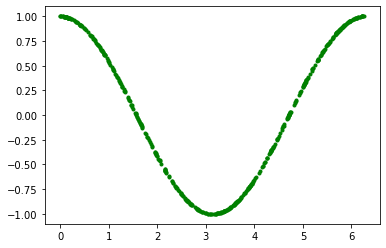

In [91]:
# Jumlah sampel angka. Kita akan membuat grafik fungsi cos, dengan beberapa angka yang acak. Disini kita melakukan generasi beberapa nilai angka.

SAMPLES = 500
# Jika akan mengganti jumlah titik, dilakukan dengan mengganti angka SAMPLES = 100 atau 500

# Membuat data dengan distribusi uniform, berdasarkan angka acak, dengan nilai 0 hingga 2π, yang merepresentasikan dari gelombang cos.
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Nilai diacak supaya tidak berurutan.
np.random.shuffle(x_values)

# Menghitung nilai cos(x), yang akan di plot menjadi sumbu y grafik
y_values = np.cos(x_values).astype(np.float32)

# Melakukan plot data ke grafik, kita lihat apakah yang akan terjadi, seharusnya muncul grafik fungsi cos, dengan titik-titik warna hijau (green g.)
plt.plot(x_values, y_values, 'g.')
plt.show()

### Membuat Noise


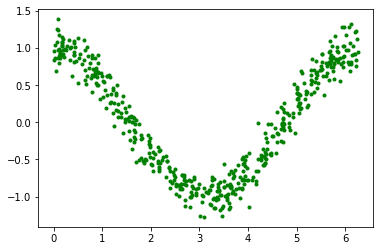

In [92]:
# Add a small random number to each y value
y_values += 0.15 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'g.')
plt.show()

#Kita lihat jika data menjadi teracak 15% dari kondisi normal, dapat dilihat seperti grafik di bawah: 

### Melakukan Pemecahan Data

Untuk mengevaluasi model yang akan kita buat, kita perlu membandingkan prediksi nilai terhadap data aslinya. Lalu kita cek, apakah cocok. Evaluasi ini berlangsung ketika training model 'validasi data', maupun setelah training 'data testing'. Perlu digarisbwahi bahwa kita menggunakan data yang berbeda, untuk training, validasi maupun testing.

Pembagian data kita lakukan sebagai berikut :
  1. Data Training : 60%
  2. Data Validasi : 20%
  3. Data Testing  : 20% 

Lalu kita akan melakukan visualisasi data, dengan grafik, untuk data training kita beri warna titik biru, data test merah dan data validasi kuning.

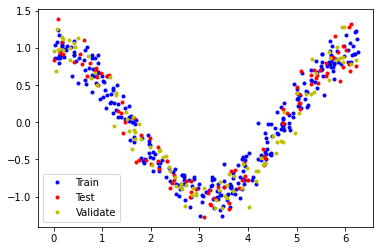

In [93]:
# Kita pecah 60% untuk training, 20 % untuk data test, dan sisanya (20%) untuk data validasi.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Kita gunakan np.split untuk membagi data menjadi 3 bagian (data train, data test, data validasi)
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Cek apakah jumlah bagian (data train+data validasi+data test) sudah sama dengan total data (samples)
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Kita lakukan plot di grafik :
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Melakukan Training Model

### 1. Membuat Desain Model
Kita akan membuat model dengan beberapa lapis neuron. 

In [94]:
#dibuat model berupa Sequential dari Keras, TensorFlow.
model = tf.keras.Sequential()

# Layer Pertama mengambil input tunggal dari data cos di atas, lalu diolah dalam 16 neuron, menggunakan 'relu' sebagai fungsi aktivasi.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# Membuat layer ke dua dan ke tiga dengan 16 neuron untuk layer 2 dan 4 neuron untuk layer ketiga, masih menggunakan relu sebagai fungsi aktivasi.
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(4, activation='relu'))

# Output akhir berupa single neuron, yang melakukan output 1 variabel
model.add(keras.layers.Dense(1))

# Dilakukan pembentukan model dengan metode optimisasi:'adam'. Dilakukan evaluasi berupa Mean Squared Error (mse), yang merupakan loss dari metode regresi.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

### 2. Melakukan Training pada Model ###

In [95]:
#Membuat class early stop yang berguna untuk menghentikan training model saat mencapai loss kurang dari 0.028
#fungsi ini digunakan agar tidak mengalami overfitting pada model

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') < 0.028):
      print('\n Loss is low so stop training')
      self.model.stop_training=True

In [96]:
callbacks = MyCallback()

In [97]:
# Dilakukan training dengan epoch (siklus perulangan) sebanyak 500 kali. Melakukan training 64 data per epoch.

history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate),
                    callbacks=[callbacks])

# Jangan lupa model disimpan
model.save(MODEL_TF)

Epoch 1/500
5/5 [==============================] - 1s 36ms/step - loss: 0.8807 - mae: 0.7570 - val_loss: 0.7110 - val_mae: 0.6814
Epoch 2/500
5/5 [==============================] - 0s 8ms/step - loss: 0.6604 - mae: 0.6911 - val_loss: 0.6092 - val_mae: 0.6679
Epoch 3/500
5/5 [==============================] - 0s 7ms/step - loss: 0.5515 - mae: 0.6542 - val_loss: 0.5749 - val_mae: 0.6741
Epoch 4/500
5/5 [==============================] - 0s 7ms/step - loss: 0.5150 - mae: 0.6348 - val_loss: 0.5800 - val_mae: 0.6882
Epoch 5/500
5/5 [==============================] - 0s 6ms/step - loss: 0.5085 - mae: 0.6301 - val_loss: 0.5945 - val_mae: 0.6971
Epoch 6/500
5/5 [==============================] - 0s 6ms/step - loss: 0.5162 - mae: 0.6340 - val_loss: 0.6014 - val_mae: 0.7004
Epoch 7/500
5/5 [==============================] - 0s 7ms/step - loss: 0.5191 - mae: 0.6350 - val_loss: 0.5990 - val_mae: 0.6989
Epoch 8/500
5/5 [==============================] - 0s 7ms/step - loss: 0.5149 - mae: 0.6333 - va

## Evaluasi Model

### 3. Plot Parameter Output (MSE)

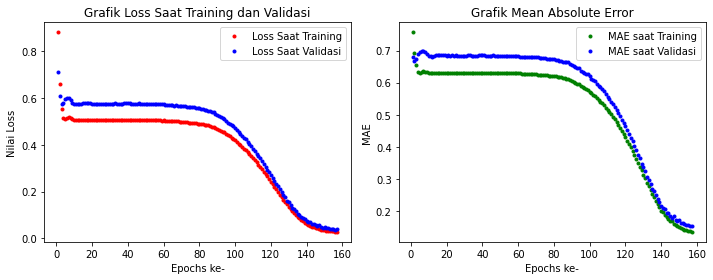

In [98]:
# Dilakukan plotting hasil training tadi, menggunakan grafik loss (loss dan val_loss), serta menggunakan MAE (mae, val_mae)

#1. Grafik Loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r.', label='Loss Saat Training')
plt.plot(epochs, val_loss, 'b.', label='Loss Saat Validasi')
plt.title('Grafik Loss Saat Training dan Validasi')
plt.xlabel('Epochs ke-')
plt.ylabel('Nilai Loss')
plt.legend()
plt.subplot(1, 2, 2)

# 2. Grafik mean absolute error
train_mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs, train_mae, 'g.', label='MAE saat Training')
plt.plot(epochs, val_mae, 'b.', label='MAE saat Validasi')
plt.title('Grafik Mean Absolute Error')
plt.xlabel('Epochs ke-')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()

### 3. Plot Hasil Prediksi

4/4 [==============================] - 0s 3ms/step - loss: 0.0340 - mae: 0.1463


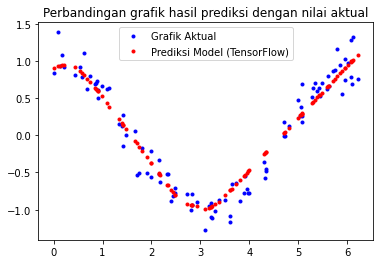

In [99]:
# Kalkulasi hasil
test_loss, test_mae = model.evaluate(x_test, y_test)

# Membuat prediksi dengan dat test
y_test_pred = model.predict(x_test)

# Membuat grafik perbandingan nilai aktual dengan prediksi
plt.clf()
plt.title('Perbandingan grafik hasil prediksi dengan nilai aktual')
plt.plot(x_test, y_test, 'b.', label='Grafik Aktual')
plt.plot(x_test, y_test_pred, 'r.', label='Prediksi Model (TensorFlow)')
plt.legend()
plt.show()